In [45]:
import mne
import numpy as np
from scipy.stats import ttest_rel
from mne.time_frequency import tfr_multitaper

vhdr_file_path = "/Users/yamandeepsoni/Downloads/ds004147/sub-27/eeg/sub-27_task-casinos_eeg.vhdr"
# Load the EEG data without preloading
raw = mne.io.read_raw_brainvision(vhdr_file_path, preload=False)

# Downsample the data to reduce memory usage (e.g., 256 Hz)
raw.resample(256, npad="auto")

# Load data for further processing
raw.load_data()


Extracting parameters from /Users/yamandeepsoni/Downloads/ds004147/sub-27/eeg/sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 809375 (3161.6 s), ~191.5 MB, data loaded>

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Fitting ICA to data using 31 channels (please be patient, this may take a while)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Selecting by number: 20 components
Fitting ICA took 5.6s.
No EOG channels found. Skipping ICA for EOG artifacts.


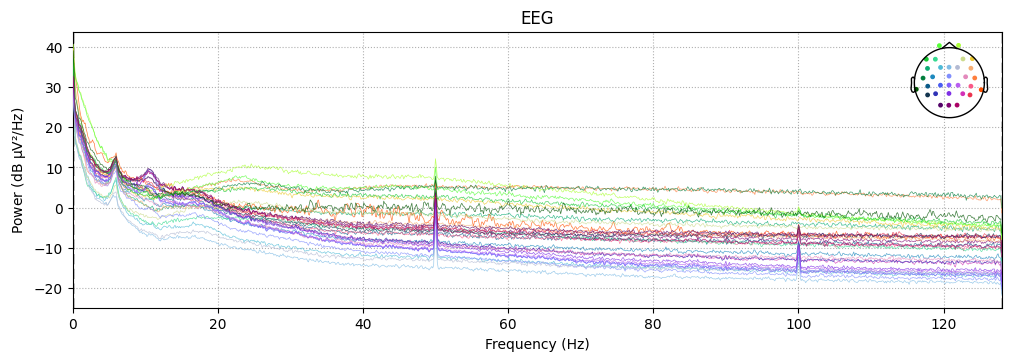

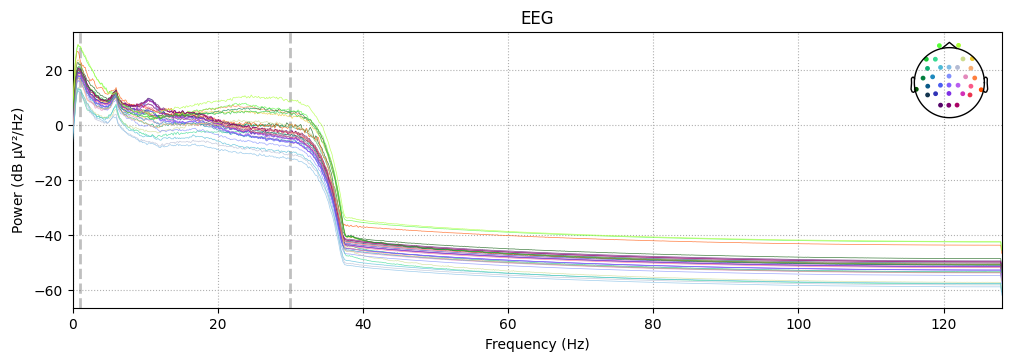

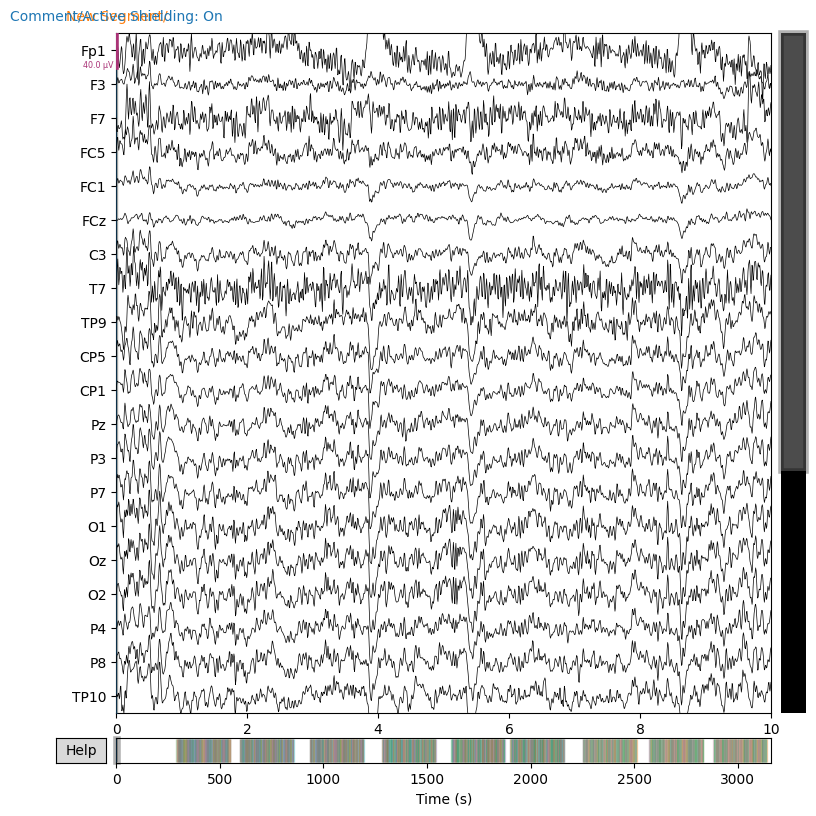

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).
Creating RawArray with float64 data, n_channels=20, n_times=809375
    Range : 0 ... 809374 =      0.000 ...  3161.617 secs
Ready.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


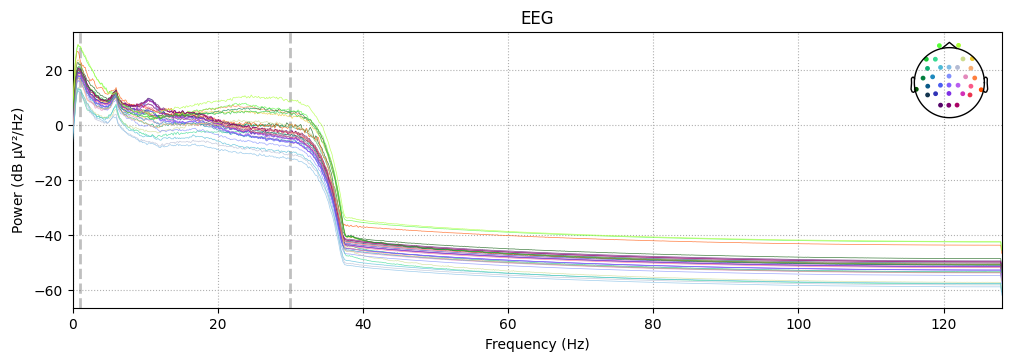

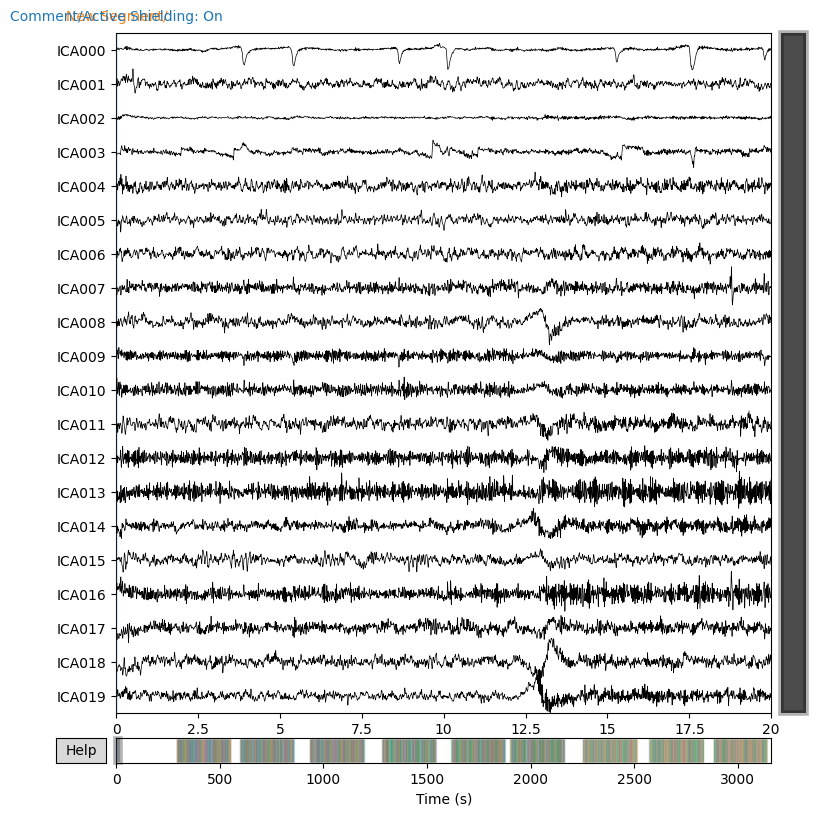

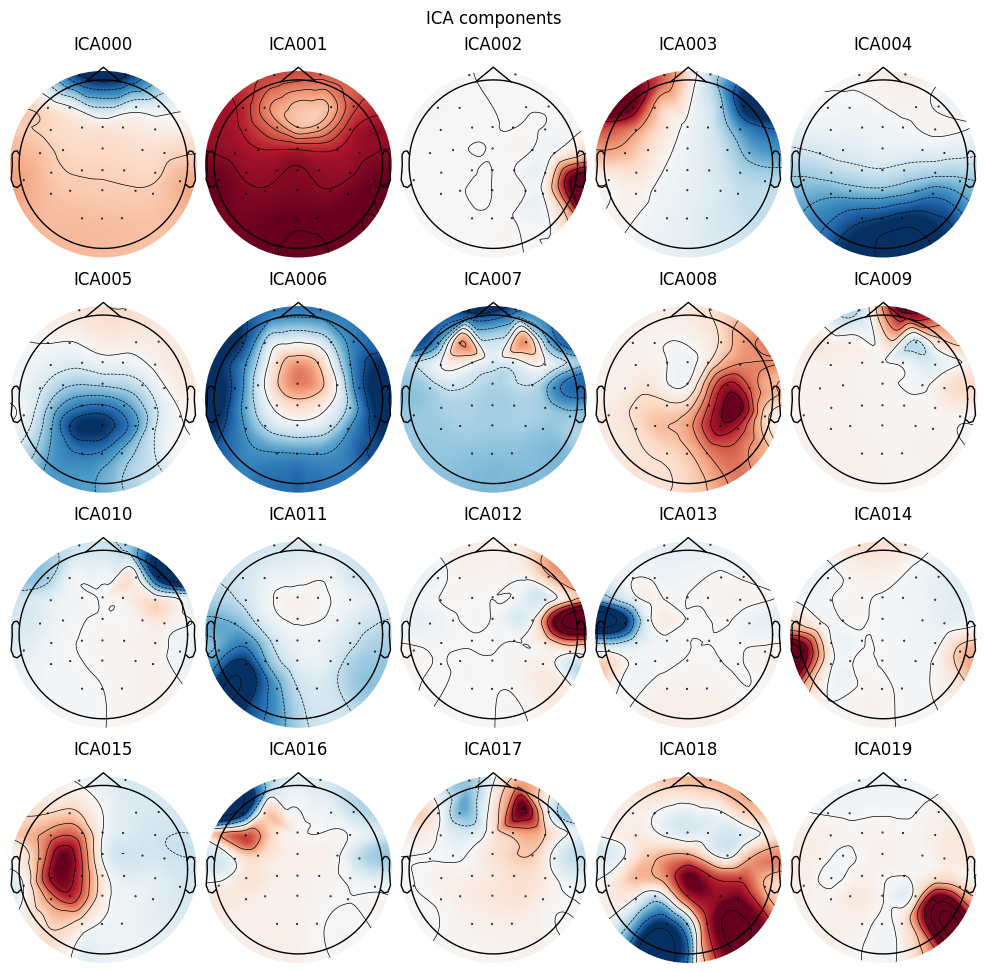

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components


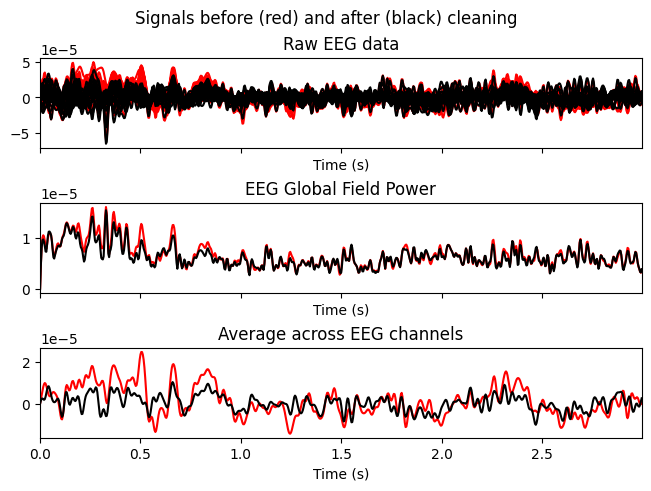

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1580 matching events found
No baseline correction applied
0 projection items activated


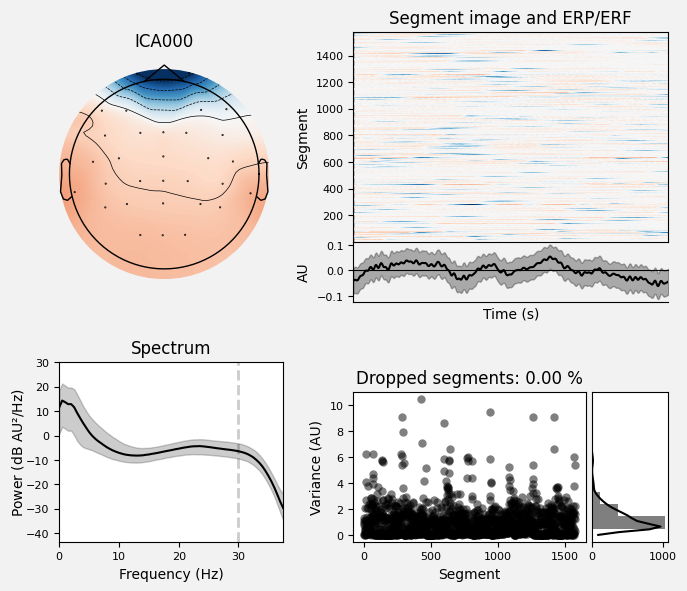

In [46]:
from mne.preprocessing import ICA, create_eog_epochs
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Plot the PSD before filtering
raw.compute_psd().plot();

# Step 3: Bandpass filtering for ICA (1-30 Hz)
raw.filter(l_freq=1.0, h_freq=30.0, method='fir', fir_design='firwin')
# Notch filtering (50/60 Hz)
raw.notch_filter(freqs=[50, 60], method='fir', fir_design='firwin')

# Plot the PSD after filtering
raw.compute_psd().plot();

# Step 4: Initialize and fit ICA

eog_channels = mne.pick_types(raw.info, meg=False, eeg=False, eog=True)
 # Step 3: Fit ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
ica.fit(raw)
if len(eog_channels) == 0:
    print("No EOG channels found. Skipping ICA for EOG artifacts.")
else:
    # Step 4: Correlate ICA components with the EOG channel
    eog_inds, scores = ica.find_bads_eog(raw)

    # Step 5: Plot correlation scores and inspect ICA components
    ica.plot_scores(scores)  # Plot correlation scores
    ica.plot_sources(raw)  # Inspect ICA source time courses

    # Step 6: Mark and exclude artifact-related components
    ica.exclude = eog_inds
    ica.apply(raw)

# Step 7: Visualize the cleaned data
raw.plot();  # Inspect the cleaned EEG signals
raw.compute_psd().plot();  # Check the power spectral density after cleaning

# Step 5: Visualize ICA components
ica.plot_sources(raw);
ica.plot_components();
ica.plot_overlay(raw, exclude=[1, 2]);
ica.plot_properties(raw, picks=[0]);

In [44]:
# Detect events from annotations (or extract them if present in raw data)
events, event_id = mne.events_from_annotations(raw)

# View the extracted events and their types
print("Events:\n", events)
print("Event IDs:\n", event_id)

# Step 7: Define epoch parameters
tmin, tmax = -0.2, 0.6  # Time range in seconds

# Detect events
events, event_id = mne.events_from_annotations(raw)
print("Detected events:", event_id)

# Extract relevant cue-locked event IDs
cue_event_id = {key: event_id[key] for key in event_id if key in [
    'Stimulus/S  2', 'Stimulus/S 12', 'Stimulus/S 22', 'Stimulus/S 32']}

# Extract relevant feedback-locked event IDs
feedback_event_id = {key: event_id[key] for key in event_id if key in [
    'Stimulus/S  6', 'Stimulus/S 16', 'Stimulus/S 26', 'Stimulus/S 36']}

print("Cue Event IDs:", cue_event_id)
print("Feedback Event IDs:", feedback_event_id)

# Define rejection criteria
reject_criteria = dict(eeg=150e-6)  # Add 150 µV threshold for EOG channels

# Create cue-locked epochs with artifact rejection
cue_epochs = mne.Epochs(
    raw, events, event_id=cue_event_id, tmin=tmin, tmax=tmax,
    baseline=(None, 0), reject=reject_criteria, preload=True, reject_by_annotation=True
)
cue_epochs.save("subject27_cue_epochs-epo.fif", overwrite=True)

# Create feedback-locked epochs with artifact rejection
feedback_epochs = mne.Epochs(
    raw, events, event_id=feedback_event_id, tmin=tmin, tmax=tmax,
    baseline=(None, 0), reject=reject_criteria, preload=True, reject_by_annotation=True
)
feedback_epochs.apply_baseline((None, 0))
feedback_epochs.save("subject27_feedback_epochs-epo.fif", overwrite=True)

# Save epochs
cue_epochs.save("subject27_cue_epochs-epo.fif", overwrite=True)
feedback_epochs.save("subject27_feedback_epochs-epo.fif", overwrite=True)

# Print details of dropped epochs
print(f"Number of cue epochs dropped: {cue_epochs.drop_log_stats()}") 
print(f"Number of feedback epochs dropped: {feedback_epochs.drop_log_stats()}")



Used Annotations descriptions: [np.str_('Comment/Active Shielding: On'), np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 16'), np.str_('Stimulus/S 17'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32'), np.str_('Stimulus/S 33'), np.str_('Stimulus/S 34'), np.str_('Stimulus/S 35'), np.str_('Stimulus/S 36'), np.str_('Stimulus/S 37')]
Events:
 [[     0      0  99999]
 [     0      0  10001]
 [ 74436      0      1]
 ...
 [803396      0     33]
 [803428      0     34]
 [804047      0     36]]
Event IDs:
 {np

Overwriting existing file.
Overwriting existing file.
P300 Peak at FCz: Amplitude = 1.3370433534828652e-06 µV, Latency = Pz s


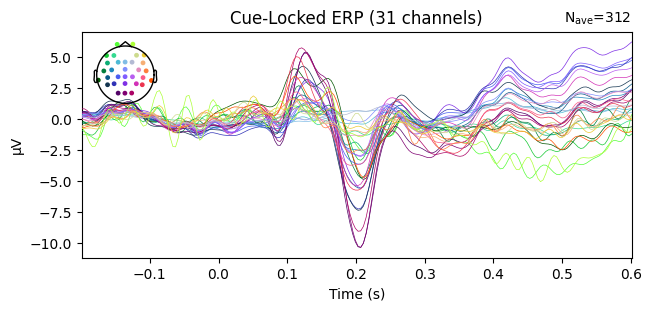

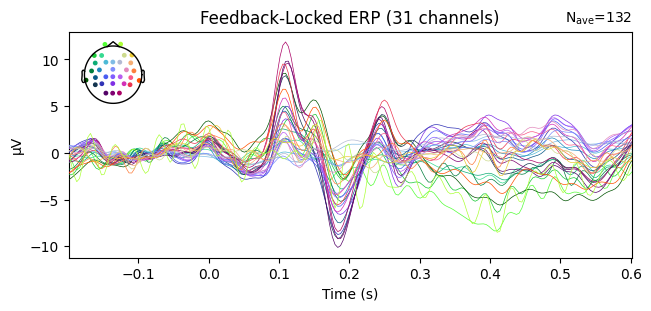

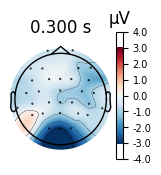

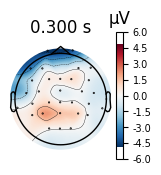

Paired t-test: t = [ 4.79884305e+00  5.74799008e+00  6.19094810e+00  4.54602390e+00
  2.42279579e+00  1.35156597e+00  9.17047815e-01  4.57133461e-01
 -4.70372789e-01 -1.93182480e+00 -3.91642278e+00 -6.20951502e+00
 -8.29041831e+00 -9.62811485e+00 -9.92354808e+00 -8.81097053e+00
 -5.63405461e+00 -7.79987066e-01  3.51022453e+00  6.16757529e+00
  7.01237274e+00  5.39328543e+00  2.54036995e+00  1.58463274e-01
 -1.83846134e+00 -3.57033372e+00 -3.80236899e+00 -3.20152499e+00
 -2.67635131e+00 -1.99868815e+00 -2.65668022e-01  3.74696732e+00
  6.59415636e+00  7.30816471e+00  7.31758218e+00  6.71697961e+00
  5.30331160e+00  3.12411721e+00  9.35283647e-01  4.00702636e-02
  7.42747645e-01  2.03036435e+00  2.96513263e+00  2.93342886e+00
  1.79566999e+00  2.19283811e-01 -1.04297661e+00 -1.65948082e+00
 -1.47086370e+00 -4.88916097e-01  6.76283183e-01  1.21987255e+00
  1.05365142e+00  4.78597786e-01 -2.22038428e-01 -8.13452390e-01
 -1.01145421e+00 -4.70064230e-01  7.70580942e-01  1.83455516e+00
  1.83

In [47]:
# Step 6: ERP Computation
cue_evoked = cue_epochs.average()
feedback_evoked = feedback_epochs.average()
cue_evoked.save("subject27_cue_evoked-ave.fif", overwrite=True)
feedback_evoked.save("subject27_feedback_evoked-ave.fif", overwrite=True)

# Step 7: ERP Analysis
# Extract P300 peaks for Cue-locked ERP at FCz
fc_z_index = cue_evoked.info['ch_names'].index('FCz')
p300_latency, p300_amplitude = cue_evoked.get_peak(ch_type='eeg', mode='pos', tmin=0.2, tmax=0.4)
peak_amplitude_fc_z = cue_evoked.data[fc_z_index].max()
print(f"P300 Peak at FCz: Amplitude = {peak_amplitude_fc_z} µV, Latency = {p300_latency} s")

# Step 8: Visualization
# Plot ERP waveforms
cue_evoked.plot(titles="Cue-Locked ERP");
feedback_evoked.plot(titles="Feedback-Locked ERP");

# Plot topographies
cue_evoked.plot_topomap(times=[0.3])
feedback_evoked.plot_topomap(times=[0.3])

# Step 9: Statistical Comparison
# Compare ERP amplitudes for low vs. high task conditions
data_low = cue_epochs['Stimulus/S  2'].average().data
data_high = cue_epochs['Stimulus/S 32'].average().data
t_stat, p_val = ttest_rel(data_low, data_high)
print(f"Paired t-test: t = {t_stat}, p = {p_val}")

# Step 10: Save Cleaned Data
cleaned_path = "cleaned_subject27_raw.fif"
raw.save(cleaned_path, overwrite=True)
print("Artifact removal and analysis complete. Cleaned data saved to:", cleaned_path)
